# Rede neuronal recurrente

En está práctica construiremos una red neuronal recurrente para generación de texto.

Puedes descargar un conjunto de datos sobre nombres en distintos idiomas aqui: https://download.pytorch.org/tutorial/data.zip

El conjunto de datos consta de nombres en 18 idiomas, se encuentran en archivos .txt 
con el nombre del idioma en el que se encuentran.

**Punto extra**: Modifica el conjunto de datos a uno de tu propia elección, con al menos dos categorias.

In [34]:
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string
import torch
import torch.nn as nn

**Lectura de datos.** Dado que en este caso nuestros datos vienen en texto, necesitaremos realizar un 
proceso diferente para obtener los datos.

In [35]:
all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # más uno para marcar el final.

# Función auxiliar que devuelve los nombres de los archivos de una carpeta.
def findFiles(path): return glob.glob(path)

def unicodeToAscii(s):
    '''
    Función auxiliar para transformar elementos de UNICODE a ASCII
    '''
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readLines(filename):
    '''
    Función auxiliar para leer las lineas 
    '''
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []

# Itera entre los nombres de tus archivos usando findFiles. 
# Agrega cada uno de los nombres a la lista 'all_categories', eliminando la extención del archivo, 
# para ello puedes usar la función de os.path llamada splitext. 
# Lee las lineas del archivo y agregalas como lista al diccionario, usando como llave a la categoria de donde procede.

for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

# Verificamos que todo se encuentre correctamente, e imprimimos cuantas categorias tienen los datos.
n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Datos no encontrados..')

print('Número de categorias:', n_categories, all_categories)

Número de categorias: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']


## Red neuronal recurrente.

El objetivo de esta red es poder generar texto a partir de un elemento de entrada. Para ello necesitaremos 
que por cada entrada de la red, nos de como resultado una nueva letra. Sin embargo, como es una red
recurrente, también tendremos un elemento que pasará integro entre una capa y la siguiente, el cual será una
salida intermedia donde, esperadamente, podamos tener los datos de la configuarición hasta ahora. **Definiremos
el tamaño de está salida intermedia como 128**

La red se compondrá de la siguiente manera:
- Una capa completamente conectada, en donde entre la categoría a la que pertenece el elemento en one-hot encoding, la letra que trataremos en formato one-hot encoding, y el elemento intermedio obtenido por la red en el tiempo anterior. Esta capa dará como resultado la codifición intermedia, a la que llamaremos *hidden*. 
- Una capa completamente conecta donde entrará la categoría a la que pertenece el elemento en one-hot encoding, la letra que recibiremos en one-hot encoding, y el elemento intermedio obtenido en el tiempo anterior. Dara como resultado la cantidad de elementos que tendremos como salida de la red, en este casó, será el mismo tamaño que la representación de las letras en one-hot encoding.
- Una capa donde combinemos los resultados de las dos capas antriores. y obtengamos como resultado una letra en formato one-hot encoding, la cual será el elemento que necesitaremos como salida de nuestra red.
- Una capa de *Dropout* con una probabilidad 0.1 de activarse.
- Pasaremos la salida por una función *LogSoftmax*

Estos elementos se conectarán de la siguiente manera:
- Concatenaremos las entradas de la red en en un único tensor, con el cual alimentaremos a las primeras dos capas. Estpas capas no se conectan entre si.
- Concatenaremos estás dos salidas en un único tensor con el cual alimentaremos a la segunda capa. Entre estás dos capas no hay una función de activación.
- A está última capa aplicaremos la función *Dropout*.
- Al resultado del *Dropout* le aplicaremos la función *LogSoftmax*.

In [36]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        '''
        Define las capas de la red, y las funciónes que usaremos. También guarda 
        como atributo del modelo también hidden_size, ya que será útil.
        '''
        super(RNN, self).__init__()
        self.hidden_size = hidden_size

        # Capa que transforma la entrada en el espacio oculto.
        self.i2h = nn.Linear(n_categories + input_size + hidden_size, hidden_size)

        # Capa que transforma la entrada en la salida.
        self.i2o = nn.Linear(n_categories + input_size + hidden_size, output_size)

        # Capa que combina el espacio oculto con la salida para obtener la salida final.
        self.o2o = nn.Linear(hidden_size + output_size, output_size)

        # Capa de dropout para agregar ruido y prevenir overfitting.
        self.dropout = nn.Dropout(0.1)

        # Función de activación softmax para obtener probabilidades sobre las categorías.
        self.softmax = nn.LogSoftmax(dim=1)



    def forward(self, category, input, hidden):
        '''
        Define la forma en la que se aplicará el feedforward respecto a lo explicado anteriormente.
        Regresa como resultado tanto la letra obtenida por la tercer capa como la representación 
        intermedia obtenida en la primer capa.
        '''
        input_combined = torch.cat((category, input, hidden), 1)

        # Transformación hacia el espacio oculto.
        hidden = self.i2h(input_combined)

        # Transformación hacia la salida.
        output = self.i2o(input_combined)

        # Combinación del espacio oculto y la salida para obtener la salida final.
        output_combined = torch.cat((hidden, output), 1)
        output = self.o2o(output_combined)

        # Aplicación de dropout.
        output = self.dropout(output)

        # Aplicación de la función de activación softmax.
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        '''
        Debido a que necesitamos un valor de hidden para usar la red, definimos al valor en el tiempo -1 como
        un tensor de ceros.
        '''
        return torch.zeros(1, self.hidden_size)



In [37]:
import random

def randomChoice(l):
    '''
    Función para obtener un elemento aleatorio de una lista.
    '''
    return l[random.randint(0, len(l) - 1)]

def randomTrainingPair():
    '''
    Función para obtener una muestra aleatoria de una categoria aleatoria.
    '''
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [38]:
def categoryTensor(category):
    '''
    Define una función para obtener la representación en one-hot encoding a partir de la posición
    de la categoría.
    '''
    # Obtenemos el índice de la categoría en la lista de todas las categorías.
    category_index = all_categories.index(category)
    
    # Creamos un tensor de ceros con tamaño (1, n_categories).
    tensor = torch.zeros(1, n_categories)
    
    # Establecemos el valor correspondiente al índice de la categoría en 1.
    tensor[0][category_index] = 1
    return tensor


def inputTensor(line):
    '''
    Define una función para obtener la representación en one-hot encoding de cada una de las letras
    que conforman una línea. Define como resultado un tensor de dimensiones (# letras en la linea, 1, # letras).
    Puedes obtener la letra a partir del string con todas las letras anteriormente definido, y usando el método
    find.
    '''
    # Creamos un tensor de ceros con tamaño (# letras en la línea, 1, n_letters).
    tensor = torch.zeros(len(line), 1, n_letters)
    
    # Iteramos sobre cada letra en la línea.
    for li, letter in enumerate(line):
        # Obtenemos el índice de la letra en el string con todas las letras.
        letter_index = all_letters.find(letter)
        # Establecemos el valor correspondiente a 1 en la posición de la letra.
        tensor[li][0][letter_index] = 1
    return tensor

def targetTensor(line):
    '''
    Define una función donde tengas los indices de cada una de las letras de una linea,
    y agrega al final de la lista el valor para finalizar, el cual es igual al número de
    letras, ya que estamos contando a parir de 0. Regresa esta lista como un LongTensor.
    '''
    # Creamos una lista con los índices de cada letra en la línea.
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    # Agregamos el índice correspondiente al final de la línea (EOS).
    letter_indexes.append(n_letters - 1) # EOS
    # Convertimos la lista de índices a un LongTensor.
    return torch.LongTensor(letter_indexes)

In [39]:
def randomTrainingExample():
    '''
    Usando como base las funciones anteriores, define una función para obtener un ejemplar 
    de entrenamiento aleatorio. Regresa como resultado la categoría a la que pertenece
    en one-hot encoding, las letras de la linea en one-hot encoding, y los valores 
    esperados correctos de está linea, como un LongTensor.
    '''
    # Obtenemos una categoría aleatoria y una línea aleatoria de esa categoría.
    category, line = randomTrainingPair()
    
    # Convertimos la categoría en one-hot encoding.
    category_tensor = categoryTensor(category)
    
    # Convertimos las letras de la línea en one-hot encoding.
    input_line_tensor = inputTensor(line)
    
    # Obtenemos los valores esperados correctos de la línea como un LongTensor.
    target_line_tensor = targetTensor(line)
    
    return category_tensor, input_line_tensor, target_line_tensor

In [40]:
def train(category_tensor, input_line_tensor, target_line_tensor, rnn, criterion, optimizer):
    '''
    Define una función de entrenamiento únicamente para una linea. Para ello debes iterar entre los
    elementos de la linea, e ir sumando los errores obtenidos. Recuerda que antes de leer la palabra
    debes de inicializar el valor de hidden. Para poder convertir a un tensor únidimensional a 
    un vector columna puedes utilizar la función unqueeze_().
    
    Para cada letra de la palabra debes obtener su resultado tras pasarlo por la red, junto a su categoria 
    y el hidden obtenido anteriormente. Y como resultado debes obtener la siguiente letra y el nuevo valor
    de hidden. Luego obten el error de tu resultado y sumalo a tu error actual.
    
    Al finalizar la palabra realiza un paso del optmizador.
    
    Retorna el valor de tu loss, dividido entre la cantidad de letras que tenia tu palabra.
    '''
    # Inicializamos el valor de hidden.
    hidden = rnn.initHidden()

    # Inicializamos el error total.
    #loss = 0
    loss = torch.Tensor([0])

    # Hacemos que los gradientes se inicien a cero.
    rnn.zero_grad()

    # Iteramos sobre cada letra de la palabra.
    for i in range(input_line_tensor.size(0)):
        # Obtenemos la salida y el nuevo valor de hidden.
        output, hidden = rnn(category_tensor, input_line_tensor[i], hidden)

        # Obtenemos el error para la letra actual.
        l = criterion(output, target_line_tensor[i].unsqueeze_(dim=0))
        
        # Sumamos el error actual al error total.
        loss += l
    
    # Realizamos el backpropagation.
    # loss.backward()

    # Realizamos un paso del optimizador.
    optimizer.step()

    # Retornamos el valor de la loss, dividido entre la cantidad de letras de la palabra.
    return loss.item() / input_line_tensor.size(0)

In [41]:
import time
import math

def timeSince(since):
    '''
    Función auxiliar, nos servirá para monitorizar el tiempo que hemos entrenado.
    '''
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

0m 9s (5000 5%) 4.0751
0m 18s (10000 10%) 4.0962
0m 27s (15000 15%) 4.0863
0m 37s (20000 20%) 4.1041
0m 46s (25000 25%) 4.0843
0m 56s (30000 30%) 4.0933
1m 6s (35000 35%) 4.1120
1m 17s (40000 40%) 4.0606
1m 26s (45000 45%) 4.0544
1m 36s (50000 50%) 4.0689
1m 47s (55000 55%) 4.0763
1m 57s (60000 60%) 4.0839
2m 7s (65000 65%) 4.1029
2m 17s (70000 70%) 4.1106
2m 27s (75000 75%) 4.1226
2m 37s (80000 80%) 4.0730
2m 48s (85000 85%) 4.1121
2m 58s (90000 90%) 4.0630
3m 8s (95000 95%) 4.1306
3m 18s (100000 100%) 4.0363


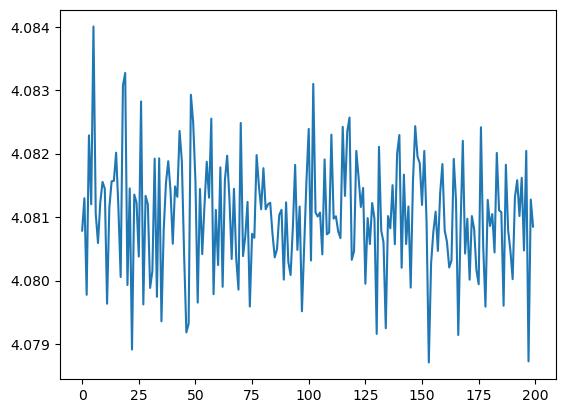

In [47]:
import matplotlib.pyplot as plt

rnn = RNN(n_letters, 128, n_letters)

n_iters = 100000
print_every = 5000
plot_every = 500
all_losses = []
total_loss = 0 # Reset every plot_every iters

criterion = nn.NLLLoss()

learning_rate = 0.00001

optimizer = torch.optim.SGD(rnn.parameters(),learning_rate)

start = time.time()

# Define un entrenamiento donde en cada iteración tomemos un elemento al azar de nuestro conjunto de datos.
# donde iteres el número de veces definido anteriormente. Suma los errores obtenidos hasta el momento, y 
# descargalos en la lista all_losses cada que pasan plot_every iteraciones, dividelo por la cantidad 
# elementos que sumaste. Imprime cada print_every el porcentaje del entrenamiento que has realizado, 
# así como cuanto tiempo lo has realizado. Al finalizar muestra la gráfica resultante de all_losses. Y 
# guarda tus pesos hasta el momento.

for iter in range(1, n_iters + 1):
    # Obtener un ejemplo de entrenamiento aleatorio.
    category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
    
    # Realizar el entrenamiento para este ejemplo.
    loss = train(category_tensor, input_line_tensor, target_line_tensor, rnn, criterion, optimizer)
    
    # Sumar el error actual al total.
    total_loss += loss

    # Imprimir el progreso cada print_every iteraciones.
    if iter % print_every == 0:
        percent = iter / n_iters * 100
        print('%s (%d %d%%) %.4f' % (timeSince(start), iter, percent, loss))

    # Guardar el error promedio cada plot_every iteraciones.
    if iter % plot_every == 0:
        avg_loss = total_loss / plot_every
        all_losses.append(avg_loss)
        total_loss = 0

# Mostrar la gráfica de los errores.
plt.figure()
plt.plot(all_losses)
plt.show()

# Guardar los pesos de la red neuronal.
torch.save(rnn.state_dict(), 'rnn_weights.pth')


In [43]:
max_length = 20

def sample(category, start_letter='A'):
    '''
    Define una función con la cual puedas obtener un nombre generado por tu red. Dode pongas como 
    inicio a la letra que selecciones en start_letter, y continues obteniendo letras a partir de ahí.
    Selecciona un tamaño máximo al cual pueda imprimir, en caso de que tu red nunca decida seleccionar
    el final de la linea.
    
    Regresa como resultado la palabra obtenida en formato string.
    '''
    with torch.no_grad():  # No necesitamos calcular gradientes para el sampling
        # Convertimos la categoría en tensor one-hot
        category_tensor = categoryTensor(category)
        # Inicializamos el valor de hidden
        hidden = rnn.initHidden()

        # Convertimos la letra de inicio en tensor one-hot
        input_tensor = inputTensor(start_letter)
        # Inicializamos el tensor de salida
        output_name = start_letter

        # Iteramos hasta alcanzar la longitud máxima o encontrar el final de la línea
        for i in range(max_length):
            # Pasamos la letra actual y el estado oculto a través de la red
            output, hidden = rnn(category_tensor, input_tensor[0], hidden)
            # Muestreamos una letra aleatoria de acuerdo a la distribución de probabilidad en output
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == n_letters - 1:  # Si es el final de la línea, terminamos el sampling
                break
            else:
                # Obtenemos la letra correspondiente al índice
                letter = all_letters[topi]
                # Añadimos la letra al nombre generado
                output_name += letter
                # Preparamos la siguiente entrada como la letra generada actual
                input_tensor = inputTensor(letter)

        return output_name

Para finalizar, muestra una palabra obtenida de cada categoria.

In [48]:

# Generamos 5 nombres aleatorios para cada categoría
for category in all_categories:
    print(category)
    for i in range(1):
        print(sample(category))
    print()



Arabic
ActjStxStDtxStDcttSSc

Chinese
AGSSSSSSSSSSSSSSSSSSS

Czech
AiiiiiiiDiiDiiDDiDDiD

Dutch
AiicfQxiicxiciiciicii

English
AHHSicHHSicHSHHHHHHSw

French
AtbtxttxttxttxtxttiSt

German
AGQDDDDDDxMQDQDDDDDxM

Greek
AcjjjjjjiDxxuxDDDDDxD

Irish
AcbdbDDDctDDDDDDDDDDD

Italian
AiSwQHSwQH'ex'exexQxQ

Japanese
AiciiDDDDDDDDDDDDDDDD

Korean
AiDDDDDDDctDDDDDDDDDD

Polish
AcjQHSwQSwQHSwQSwQHSw

Portuguese
ADDDDDDDDDDDDDDDDfDtD

Russian
ADDDDDDDDDDxHHDDDDDDD

Scottish
ADxDDDDDDDDDDDDDDDDDD

Spanish
AxxxxxxxxxxxxMxxxxMxx

Vietnamese
AiDDDDDDDDDDDDDDDDDxt

